In [1]:
from snowflake.snowpark import (
    Session,
    functions as F, 
    types as T
)
import os
import json
import pandas as pd
import datetime
import calendar
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import IsolationForest


In [2]:
connection_params = json.loads(os.environ["AIRFLOW_CONN_SNOWFLAKE_PROD"])
connection_params['user'] = connection_params.pop('login')
connection_params['account'] = connection_params['extra'].pop('account')
connection_params['database'] = connection_params['extra'].pop('database')
connection_params['schema'] = connection_params['schema']
connection_params['region'] = connection_params['extra'].pop('region')
connection_params['application'] = connection_params['extra'].pop('application')
snowpark_session = Session.builder.configs(connection_params).create()

In [3]:
account_start_cutoff_date = datetime.date(2022, 11, 15)

In [4]:
currency_usage = snowpark_session.table('SNOWFLAKE.ORGANIZATION_USAGE.USAGE_IN_CURRENCY_DAILY')

In [62]:
usage = currency_usage.filter((F.col('USAGE_DATE') >= account_start_cutoff_date) &
                              (F.col('USAGE_DATE') < datetime.date.today()))

usage_df = usage.select('USAGE_DATE', 'USAGE_TYPE', 'USAGE')\
                         .pivot(pivot_col='USAGE_TYPE', values=["compute", "storage"])\
                         .sum('USAGE')\
                         .sort('USAGE_DATE')\
                         .to_pandas()

usage_df.columns = ["date", "compute", "storage"]
usage_df.date = pd.to_datetime(usage_df.date)
usage_df.set_index('date', inplace=True)
usage_df.fillna(value=0, inplace=True)
usage_df = usage_df.apply(pd.to_numeric, downcast='float')
usage_df

,compute,storage
date,,
2022-11-15,99.836388,0.051697
2022-11-16,105.160004,0.051572
2022-11-17,120.424446,0.051844
2022-11-18,93.476669,0.051519
2022-11-19,48.338055,0.052095
...,...,...
2023-11-30,120.711945,0.193031
2023-12-01,135.488052,0.189543
2023-12-02,86.926941,0.191458


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


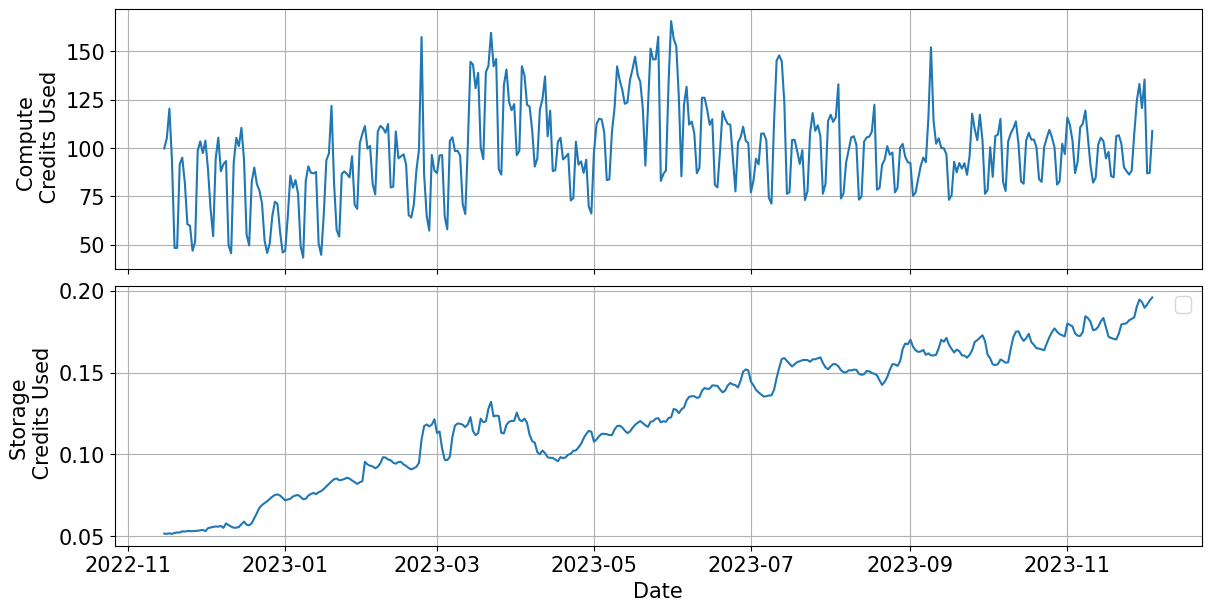

In [63]:
plt.rc('figure',figsize=(12,6))
plt.rc('font',size=15)

fig, axs = plt.subplots(2, 1, sharex='all', layout='constrained')
axs[0].plot(usage_df['compute'])
axs[0].set_ylabel('Compute \n Credits Used')
axs[0].grid(True)

axs[1].plot(usage_df['storage'])
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Storage \n Credits Used')
axs[1].grid(True)
plt.legend()
plt.show()

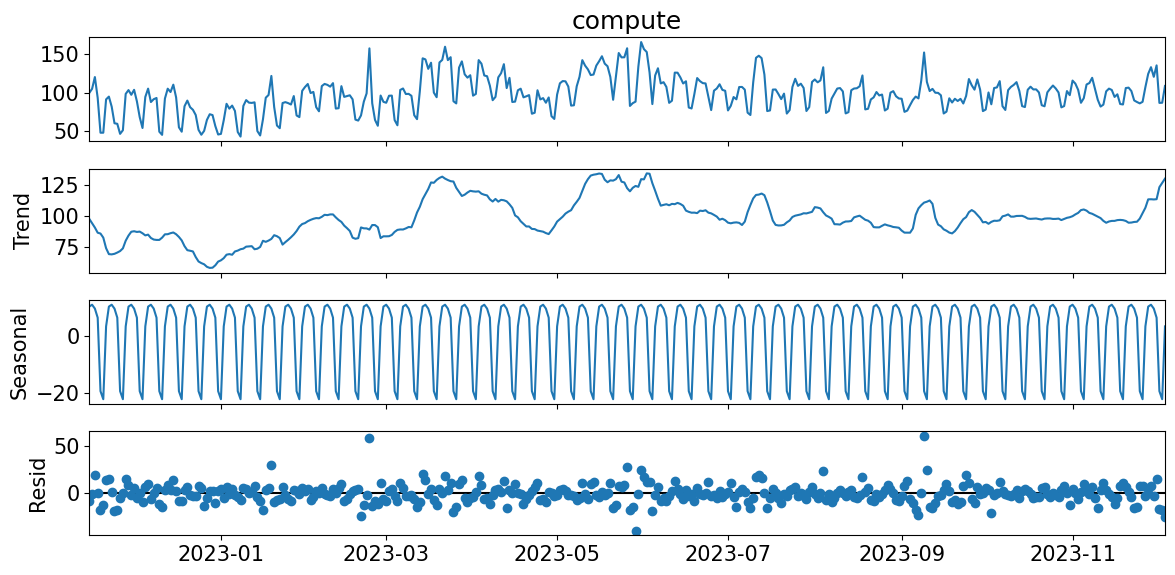

In [64]:
compute_stl = seasonal_decompose(x=usage_df.compute, model='additive', extrapolate_trend='freq')
compute_stationary = compute_stl.resid.values.reshape(-1,1)
fig = compute_stl.plot()


In [75]:
compute_model =  IsolationForest()
compute_model.fit(compute_stationary)

usage_df['compute_scores'] = compute_model.decision_function(compute_stationary) 
compute_threshold = usage_df['compute_scores'].mean() - (3 * usage_df['compute_scores'].std())

date
2022-11-15    0.053952
2022-11-16    0.097077
2022-11-17   -0.092983
2022-11-18    0.101193
2022-11-19   -0.069033
                ...   
2023-11-30    0.092324
2023-12-01   -0.059917
2023-12-02   -0.048004
2023-12-03   -0.039747
2023-12-04   -0.202730
Name: compute_scores, Length: 385, dtype: float64

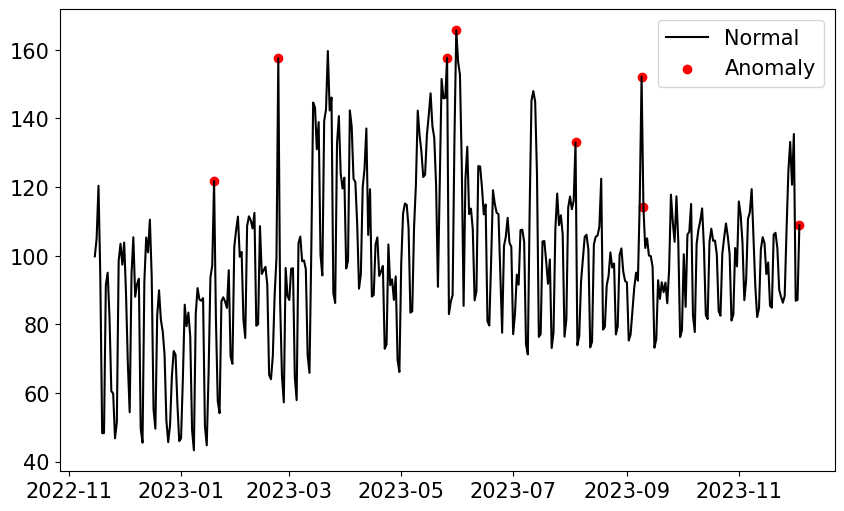

In [77]:
fig, ax = plt.subplots(figsize=(10,6))

anomalies = usage_df.loc[(usage_df.compute_scores <= compute_threshold) & 
                         (usage_df.compute > usage_df.compute.mean()), ['compute']]
anomalies

ax.plot(usage_df.index, usage_df.compute, color='black', label = 'Normal')
ax.scatter(anomalies.index, anomalies.compute, color='red', label = 'Anomaly')
plt.legend()
plt.show()


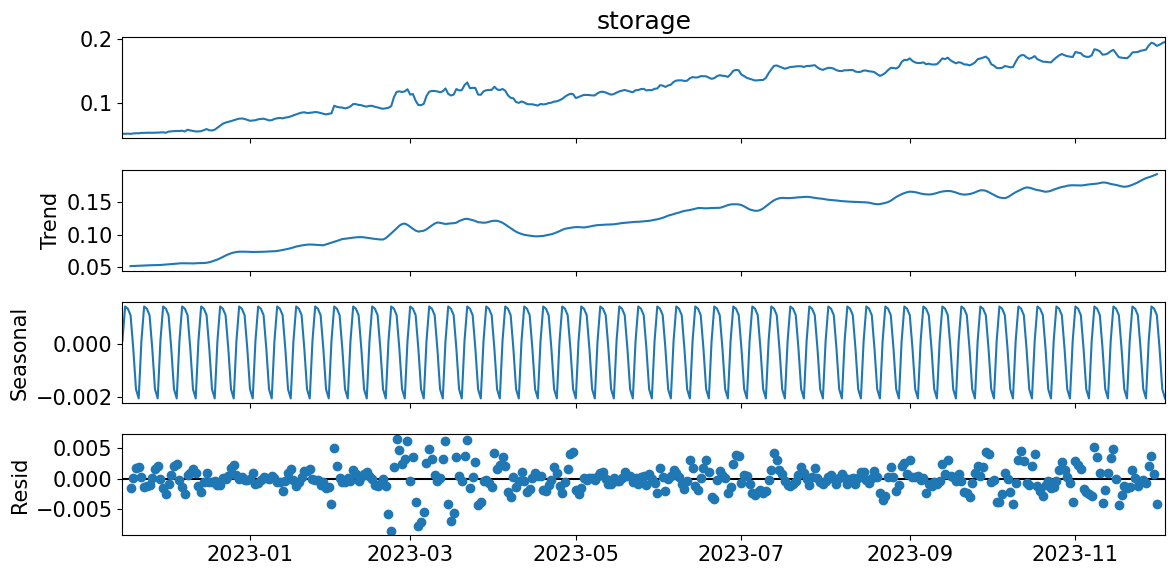

In [10]:
storage_stl = seasonal_decompose(usage_df.storage, model='additive')
storage_stationary = storage_stl.resid.values.reshape(-1,1)
fig = storage_stl.plot()

In [79]:
storage_model =  IsolationForest()
storage_model.fit(storage_stationary)

usage_df['storage_scores'] = storage_model.decision_function(storage_stationary) 
storage_threshold = usage_df['storage_scores'].mean() - (3 * usage_df['storage_scores'].std())

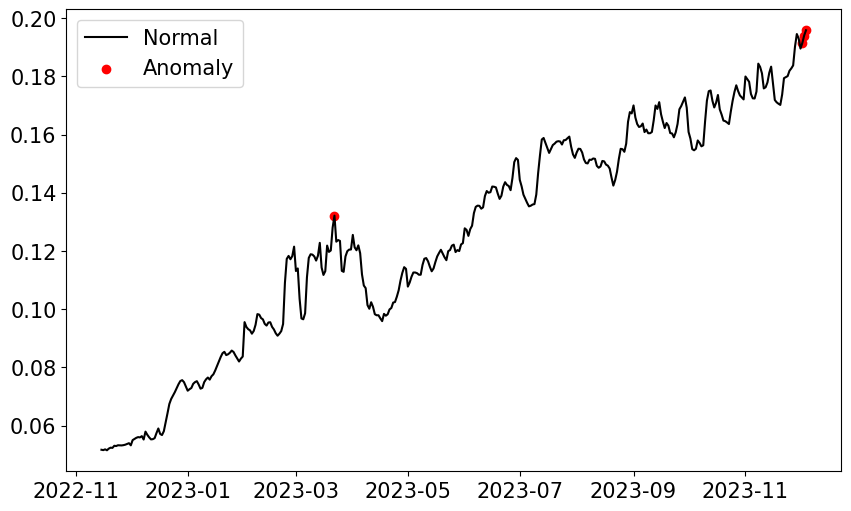

In [80]:
fig, ax = plt.subplots(figsize=(10,6))

anomalies = usage_df.loc[(usage_df.storage_scores <= storage_threshold) & 
                         (usage_df.storage > usage_df.storage.mean()), ['storage']]
anomalies

ax.plot(usage_df.index, usage_df.storage, color='black', label = 'Normal')
ax.scatter(anomalies.index, anomalies.storage, color='red', label = 'Anomaly')
plt.legend()
plt.show()


In [17]:
usage_df = usage.select('USAGE_DATE', 'USAGE_TYPE', 'USAGE')\
                         .pivot(pivot_col='USAGE_TYPE', values=["compute", "storage"])\
                         .sum('USAGE')\
                         .sort('USAGE_DATE')\
                         .to_pandas()\

usage_df.columns = ["date", "compute", "storage"]
usage_df.date = pd.to_datetime(usage_df.date)
usage_df.set_index('date', inplace=True)
usage_df.fillna(value=0, inplace=True)
usage_df = usage_df.apply(pd.to_numeric, downcast='float')


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
import tensorflow as tf
import keras

scalar = StandardScaler()
data = scalar.fit_transform(usage_df)

ds = tf.keras.preprocessing.timeseries_dataset_from_array(
     data=data,
     targets=data,
     sequence_length=7)

X, y = next(iter(ds))

model = keras.Sequential(
    [
        keras.layers.LSTM(
            units=64, 
            kernel_initializer='he_uniform', 
            batch_input_shape=(None, X.shape[1], X.shape[2]), 
            return_sequences=True, 
            # activation='relu',
            name='enc1'),
        keras.layers.LSTM(
            units=32, 
            kernel_initializer='he_uniform', 
            return_sequences=True, 
            # activation='relu',
            name='enc2'),
        keras.layers.LSTM(
            units=16, 
            kernel_initializer='he_uniform', 
            return_sequences=False, 
            # activation='relu',
            name='enc3'),
        keras.layers.RepeatVector(
            n=7, 
            name='encoder_decoder_bridge'),
        keras.layers.LSTM(
            units=16, 
            kernel_initializer='he_uniform', 
            return_sequences=True, 
            # activation='relu',
            name='dec1'),
        keras.layers.LSTM(
            units=32, 
            kernel_initializer='he_uniform', 
            return_sequences=True, 
            # activation='relu',
            name='dec2'),
        keras.layers.LSTM(
            units=64, 
            kernel_initializer='he_uniform', 
            return_sequences=True, 
            # activation='relu',
            name='dec3'),
        keras.layers.TimeDistributed(layer=keras.layers.Dense(X.shape[2]))
    ]
)

model.compile(loss="mse", optimizer=tf.keras.optimizers.legacy.Adam()) #(learning_rate=0.001))
model.build()
# print(model.summary())

history = model.fit(
    x=X,
    y=X,
    epochs=200,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", 
                                      patience=40, 
                                      mode="min")
    ],
)


Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 1.4646 - val_loss: 1.4834
Epoch 2/200
1/1 [==============================] - 0s 25ms/step - loss: 1.3479 - val_loss: 1.4887
Epoch 3/200
1/1 [==============================] - 0s 24ms/step - loss: 1.2467 - val_loss: 1.4951
Epoch 4/200
1/1 [==============================] - 0s 27ms/step - loss: 1.1599 - val_loss: 1.5028
Epoch 5/200
1/1 [==============================] - 0s 25ms/step - loss: 1.0854 - val_loss: 1.5118
Epoch 6/200
1/1 [==============================] - 0s 28ms/step - loss: 1.0215 - val_loss: 1.5221
Epoch 7/200
1/1 [==============================] - 0s 26ms/step - loss: 0.9665 - val_loss: 1.5335
Epoch 8/200
1/1 [==============================] - 0s 27ms/step - loss: 0.9196 - val_loss: 1.5451
Epoch 9/200
1/1 [==============================] - 0s 27ms/step - loss: 0.8803 - val_loss: 1.5559
Epoch 10/200
1/1 [==============================] - 0s 25ms/step - loss: 0.8485 - val_loss: 1.5643
Epoch 11/200
1/1 [===

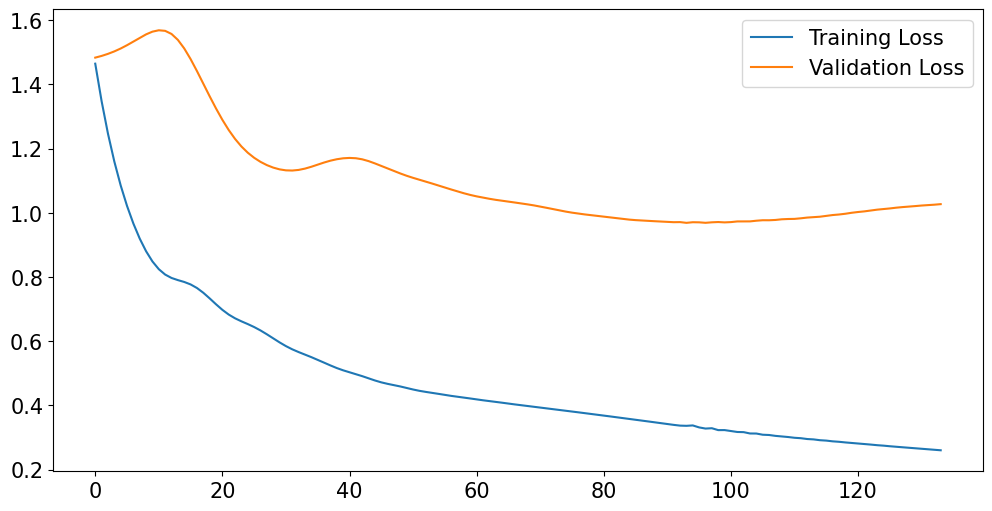

In [21]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [81]:
import numpy as np
X_pred = model.predict(X)
mse = np.mean(np.power(X - X_pred, 2), axis=1)

4/4 [==============================] - 1s 3ms/step


In [82]:
forecast_df = pd.DataFrame(scalar.inverse_transform(mse), columns=usage_df.columns)
pred_df = pd.DataFrame(mse, columns=usage_df.columns)

ValueError: Shape of passed values is (128, 2), indices imply (128, 4)

In [ ]:
pred_df.loc[0]

In [ ]:
#normal day
usage_df.iloc[-4]

In [ ]:
plt.plot(pred_df.compute, label="Compute")
plt.plot(pred_df.storage, label="Storage")
plt.legend()
plt.show()